In [32]:
import pandas as pd
import numpy as np
import torch
import pickle
import os
import json
import gc
from torch.distributions import Bernoulli
from torch.optim import LBFGS
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tueplots import bundles
bundles.icml2024()

from torchmetrics import AUROC
auroc = AUROC(task="binary")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def visualize_response_matrix(results, value, filename):
    # Extract the groups labels in the order of the columns
    group_values = results.columns.get_level_values("scenario")

    # Identify the boundaries where the group changes
    boundaries = []
    for i in range(1, len(group_values)):
        if group_values[i] != group_values[i - 1]:
            boundaries.append(i - 0.5)  # using 0.5 to place the line between columns

    # Visualize the results with a matrix: red is 0, white is -1 and blue is 1
    cmap = mcolors.ListedColormap(["white", "red", "blue"])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Calculate midpoints for each group label
    groups_list = list(group_values)
    group_names = []
    group_midpoints = []
    current_group = groups_list[0]
    start_index = 0
    for i, grp in enumerate(groups_list):
        if grp != current_group:
            midpoint = (start_index + i - 1) / 2.0
            group_names.append(current_group)
            group_midpoints.append(midpoint)
            current_group = grp
            start_index = i
    # Add the last group
    midpoint = (start_index + len(groups_list) - 1) / 2.0
    group_names.append(current_group)
    group_midpoints.append(midpoint)

    # Define the minimum spacing between labels (e.g., 100 units)
    min_spacing = 100
    last_label_pos = -float("inf")
    # Plot the matrix
    with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
        fig, ax = plt.subplots(figsize=(20, 10))
        cax = ax.matshow(value, aspect="auto", cmap=cmap, norm=norm)

        # Add vertical lines at each boundary
        for b in boundaries:
            ax.axvline(x=b, color="black", linewidth=0.25, linestyle="--", alpha=0.5)
        
        # Add group labels above the matrix, only if they're spaced enough apart
        for name, pos in zip(group_names, group_midpoints):
            if pos - last_label_pos >= min_spacing:
                ax.text(pos, -5, name, ha='center', va='bottom', rotation=90, fontsize=3)
                last_label_pos = pos

        # Add model labels on the y-axis
        ax.set_yticks(range(len(results.index)))
        ax.set_yticklabels(results.index, fontsize=3)

        # Add a colorbar
        cbar = plt.colorbar(cax)
        cbar.set_ticks([-1, 0, 1])
        cbar.set_ticklabels(["-1", "0", "1"])
        plt.savefig(filename, dpi=600, bbox_inches="tight")
        plt.close()

def trainer(parameters, optim, closure, n_iter=100, verbose=True):
    pbar = tqdm(range(n_iter)) if verbose else range(n_iter)
    for iteration in pbar:
        if iteration > 0:
            previous_parameters = [p.clone() for p in parameters]
            previous_loss = loss.clone()
        
        loss = optim.step(closure)
        
        if iteration > 0:
            d_loss = (previous_loss - loss).item()
            d_parameters = sum(
                torch.norm(prev - curr, p=2).item()
                for prev, curr in zip(previous_parameters, parameters)
            )
            grad_norm = sum(torch.norm(p.grad, p=2).item() for p in parameters if p.grad is not None)
            if verbose:
                pbar.set_postfix({"grad_norm": grad_norm, "d_parameter": d_parameters, "d_loss": d_loss})
            
            if d_loss < 1e-5 and d_parameters < 1e-5 and grad_norm < 1e-5:
                break
    return parameters

def compute_auc(probs, data, train_idtor, test_idtor):
    train_probs = probs[train_idtor.bool()]
    test_probs = probs[test_idtor.bool()]
    train_labels = data[train_idtor.bool()]
    test_labels = data[test_idtor.bool()]
    train_auc = auroc(train_probs, train_labels)
    test_auc = auroc(test_probs, test_labels)
    print(f"train auc: {train_auc}")
    print(f"test auc: {test_auc}")
    
    return train_auc, test_auc

def compute_cttcorr(probs, data, train_idtor, test_idtor):
    train_probs  = probs.clone()
    test_probs   = probs.clone()
    train_labels = data.clone()
    test_labels  = data.clone()

    train_mask = ~train_idtor.bool()
    train_probs[train_mask]  = float('nan')
    train_labels[train_mask] = float('nan')

    test_mask = ~test_idtor.bool()
    test_probs[test_mask]   = float('nan')
    test_labels[test_mask]  = float('nan')
    
    train_prob_ctt = torch.nanmean(train_probs, dim=1).detach().cpu().numpy()
    train_label_ctt = torch.nanmean(train_labels, dim=1).detach().cpu().numpy()
    train_mask = ~np.isnan(train_prob_ctt) & ~np.isnan(train_label_ctt)
    train_cttcorr = pearsonr(train_prob_ctt[train_mask], train_label_ctt[train_mask]).statistic
    
    test_prob_ctt = torch.nanmean(test_probs, dim=1).detach().cpu().numpy()
    test_label_ctt = torch.nanmean(test_labels, dim=1).detach().cpu().numpy()
    test_mask = ~np.isnan(test_prob_ctt) & ~np.isnan(test_label_ctt)
    test_cttcorr = pearsonr(test_prob_ctt[test_mask], test_label_ctt[test_mask]).statistic
    
    print(f"train cttcorr: {train_cttcorr}")
    print(f"test cttcorr: {test_cttcorr}")

    return train_cttcorr, test_cttcorr

In [33]:
with open(f"../data/resmat_2000.pkl", "rb") as f:
    results = pickle.load(f)

dtype = torch.float64 if device.startswith("cuda") else torch.float32

# data_withnan, missing=nan
# data_withneg1, missing=-1
# data_with0, missing=0
data_withnan = torch.tensor(results.values, dtype=dtype, device=device)
data_idtor = (~torch.isnan(data_withnan)).to(dtype)
data_withneg1 = data_withnan.nan_to_num(nan=-1.0)
data_with0 = data_withneg1 * data_idtor
data_with0 = data_with0.nan_to_num(nan=0.0)
n_test_takers, n_items = data_with0.shape
scenarios = results.columns.get_level_values("scenario").unique()

In [34]:
master_test_df = pd.read_csv("../data/master_test_metadata_factor.csv")
final_test_data_matrix = pd.read_pickle("../data/master_test_data_matrix_factor.pkl").values
dtype = torch.float64 if device.startswith("cuda") else torch.float32
final_test_data_matrix = np.nan_to_num(final_test_data_matrix, nan=0)

In [35]:
# data_idtor = train_idtor + test_idtor
# apply random train/test mask to the matrix, and ensure no one row or column is fully masked
valid_condition = False
trial = 0
while not valid_condition:
    train_idtor = torch.bernoulli(data_idtor * 0.8).int()
    test_idtor = data_idtor - train_idtor
    valid_condition = (train_idtor.sum(axis=1) != 0).all() and (train_idtor.sum(axis=0) != 0).all()
    print(f"trial {trial} valid condition: {valid_condition}")
    trial += 1

# fit z
B = 50000
optimized_zs = []
thetas_nuisance = torch.randn(150, n_test_takers, device=device)
for i in tqdm(range(0, n_items, B)):
    data_batch = data_with0[:, i:i+B]
    train_idtor_batch = train_idtor[:, i:i+B]
    current_B = data_batch.shape[1]
    z_i = torch.randn(current_B, requires_grad=True, device=device)
    optim_z_i = LBFGS([z_i], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    def closure_z_i():
        optim_z_i.zero_grad()
        probs = torch.sigmoid(thetas_nuisance[:, :, None] + z_i[None, None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_batch)*train_idtor_batch).mean()
        loss.backward()
        return loss
    z_i_optimized = trainer([z_i], optim_z_i, closure_z_i)[0].detach()
    optimized_zs.append(z_i_optimized)
zs = torch.cat(optimized_zs)

# fit theta
thetas = torch.randn(n_test_takers, requires_grad=True, device=device)
optim_theta = LBFGS([thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
def closure_theta():
    optim_theta.zero_grad()
    probs = torch.sigmoid(thetas[:, None] + zs[None, :])
    loss = -(Bernoulli(probs=probs).log_prob(data_with0)*train_idtor).mean()
    loss.backward()
    return loss
thetas = trainer([thetas], optim_theta, closure_theta)[0]

# calculate metrics
probs = torch.sigmoid(thetas[:, None] + zs[None, :])

train_auc, test_auc = compute_auc(probs, data_with0, train_idtor, test_idtor)

train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_with0, train_idtor, test_idtor)

del optim_theta, thetas, z_i, thetas_nuisance, optim_z_i
gc.collect()
torch.cuda.empty_cache()

trial 0 valid condition: True


  0%|          | 0/1 [00:49<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn

class NeuralIRT_1PL(nn.Module):
    def __init__(self, n_test_takers, n_items, n_dimensions, q_matrix):
        super().__init__()
        
        # Person embedding layer -> learns the multidimensional thetas
        self.person_embedding = nn.Embedding(n_test_takers, n_dimensions)
        
        # <<< REMOVED: The item_a_embedding layer is gone for the 1PL model >>>
        
        # Item difficulty embedding layer -> learns the 'b' parameters
        self.item_b_embedding = nn.Embedding(n_items, 1)
        
        # <<< NEW: Store the fixed Q-matrix as a non-trainable buffer >>>
        # This is the correct way to include fixed data in a PyTorch model.
        self.register_buffer('q_matrix', q_matrix)

    def forward(self, person_ids, item_ids):
        # Look up the vectors for the given persons and items
        theta = self.person_embedding(person_ids)
        b = self.item_b_embedding(item_ids).squeeze()
        
        # <<< NEW: Look up the Q-matrix vector for the given items >>>
        q_vector = self.q_matrix[item_ids]
        
        # --- The MIRT 1PL Formula ---
        # 1. Apply the Q-matrix to select the relevant theta dimensions
        effective_theta = theta * q_vector
        
        # 2. Sum the relevant abilities (this is the dot product with a=1)
        #    and subtract the item difficulty 'b'
        logits = torch.sum(effective_theta, dim=1) - b
        
        # Apply sigmoid to get the probability
        prob = torch.sigmoid(logits)
        
        return prob

In [ ]:
# --- Build the Q-Matrix for your MASTER TEST ---
# Assume master_test_df is your (120, ...) DataFrame with the 'component' column
n_dimensions = 8 # Your MASTER TEST has 6 components

component_names = master_test_df['component'].unique()
Q_matrix_df = pd.get_dummies(master_test_df['component'])
Q_matrix_df = Q_matrix_df[component_names]
Q_matrix_tensor = torch.tensor(Q_matrix_df.values, device=device, dtype=torch.float32)

print(f"Shape of Q-Matrix: {Q_matrix_tensor.shape}") # Should be (120, 6)

Shape of Q-Matrix: torch.Size([17872, 8])


In [ ]:
print("--- Preparing Data for Neural Network Training ---")

# 1. Convert your final test data matrix to a PyTorch tensor
data_matrix = torch.tensor(final_test_data_matrix, dtype=torch.float32, device=device)
n_test_takers, n_items = data_matrix.shape # Should be 183, 120

# 2. Convert the (183, 120) "wide" matrix to a "long" format
# Get the row (person) and column (item) indices for every single interaction
person_indices, item_indices = torch.meshgrid(
    torch.arange(n_test_takers, device=device),
    torch.arange(n_items, device=device),
    indexing='ij'
)

# Flatten the indices and the corresponding answers
person_indices_flat = person_indices.flatten()
item_indices_flat = item_indices.flatten()
correct_answers_flat = data_matrix.flatten()

# 3. Stack them into the final (N, 3) training_data tensor
training_data = torch.stack([
    person_indices_flat, 
    item_indices_flat, 
    correct_answers_flat
], dim=1)

# Convert index columns to long type, which is required for nn.Embedding
training_data = training_data.to(torch.long)
training_data[:, 2] = training_data[:, 2].float() # Keep the 'is_correct' column as float

print(f"Converted matrix to long format with {len(training_data)} interactions.")
print("Example rows:\n", training_data[:5])

--- Preparing Data for Neural Network Training ---
Converted matrix to long format with 3270576 interactions.
Example rows:
 tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 2, 0],
        [0, 3, 0],
        [0, 4, 0]], device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

# ====================================================================================
# 1. PREPARE AND SPLIT THE DATA (Using Pre-defined Masks)
# ====================================================================================
print("--- Preparing and splitting data using pre-defined masks ---")

# Convert your data matrix to a PyTorch tensor
data_matrix = torch.tensor(final_test_data_matrix, dtype=torch.float32, device=device)
n_test_takers, n_items = data_matrix.shape

# --- Step A: Generate the exact train/test masks ---
# This block generates the (183, 120) masks for training and testing.
# I've added torch.manual_seed(42) to ensure this "random" split is the same every time you run the script.
data_idtor = torch.ones_like(data_matrix)
valid_condition = False
while not valid_condition:
    torch.manual_seed(42) 
    train_idtor = torch.bernoulli(data_idtor * 0.8).int()
    test_idtor = data_idtor - train_idtor
    valid_condition = (train_idtor.sum(axis=1) != 0).all() and \
                      (train_idtor.sum(axis=0) != 0).all() and \
                      (test_idtor.sum(axis=1) != 0).all() and \
                      (test_idtor.sum(axis=0) != 0).all()
print("Generated a reproducible 80/20 train/test mask.")

# <<< ADD THESE LINES TO SAVE THE MASKS >>>
torch.save(train_idtor, 'train_idtor.pt')
torch.save(test_idtor, 'test_idtor.pt')
print("Saved train_idtor.pt and test_idtor.pt for later evaluation.")

# --- Step B: Convert masks to "long format" datasets ---
def create_long_dataset_from_mask(data_matrix, idtor_mask):
    """Takes a wide data matrix and a wide mask and returns a long-format dataset."""
    # Find the (person, item) coordinates where the mask is 1
    person_indices, item_indices = idtor_mask.nonzero(as_tuple=True)
    # Get the corresponding correct answers
    labels = data_matrix[person_indices, item_indices]
    # Create the TensorDataset
    dataset = TensorDataset(person_indices, item_indices, labels)
    return dataset

train_dataset = create_long_dataset_from_mask(data_matrix, train_idtor)
test_dataset = create_long_dataset_from_mask(data_matrix, test_idtor)

# --- Step C: Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

print(f"Data split into {len(train_dataset)} training samples and {len(test_dataset)} testing samples based on the provided masks.")


# ====================================================================================
# 1. DEFINE THE EVALUATION FUNCTION (place this before the training loop)
# ====================================================================================

def evaluate_model(model, data_loader, loss_fn):
    model.eval() # Set model to evaluation mode
    all_outputs = []
    all_labels = []
    total_loss = 0.0
    with torch.no_grad():
        for person_ids, item_ids, labels in data_loader:
            person_ids, item_ids, labels = person_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = model(person_ids, item_ids)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * len(labels)
            all_outputs.append(outputs)
            all_labels.append(labels)
    
    avg_loss = total_loss / len(data_loader.dataset)
    # Use torchmetrics.AUROC for AUC calculation
    auc = auroc(torch.cat(all_outputs), torch.cat(all_labels).to(torch.long))
    return avg_loss, auc.item()


# ====================================================================================
# 2. TRAIN THE MODEL (WITH EPOCH-WISE EVALUATION)
# ====================================================================================

# Instantiate model, optimizer, etc.
model = NeuralIRT_1PL(n_test_takers, n_items, n_dimensions, q_matrix=Q_matrix_tensor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# <<< Lists to store metrics for plotting later >>>
train_losses = []
test_losses = []
test_aucs = []

n_epochs = 5
print("--- Starting Training ---")
for epoch in range(n_epochs):
    # --- Training Phase ---
    model.train() # Set model to training mode
    epoch_train_loss = 0.0
    for person_ids, item_ids, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        person_ids, item_ids, labels = person_ids.to(device), item_ids.to(device), labels.to(device)
        
        # Standard training steps
        optimizer.zero_grad()
        outputs = model(person_ids, item_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * len(labels)
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # --- Evaluation Phase ---
    # <<< Calculate test metrics at the end of each epoch >>>
    avg_test_loss, test_auc = evaluate_model(model, test_loader, loss_fn)
    test_losses.append(avg_test_loss)
    test_aucs.append(test_auc)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test AUC: {test_auc:.4f}")

print("\nTraining complete.")

--- Preparing and splitting data using pre-defined masks ---
Generated a reproducible 80/20 train/test mask.
Saved train_idtor.pt and test_idtor.pt for later evaluation.
Data split into 2617129 training samples and 653447 testing samples based on the provided masks.
--- Starting Training ---


Epoch 1 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:28<00:00, 89.31it/s]


Epoch 1 | Train Loss: 0.2681 | Test Loss: 0.1759 | Test AUC: 0.9699


Epoch 2 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:28<00:00, 88.25it/s]


Epoch 2 | Train Loss: 0.1665 | Test Loss: 0.1632 | Test AUC: 0.9728


Epoch 3 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:29<00:00, 87.68it/s]


Epoch 3 | Train Loss: 0.1603 | Test Loss: 0.1619 | Test AUC: 0.9731


Epoch 4 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:29<00:00, 87.65it/s]


Epoch 4 | Train Loss: 0.1591 | Test Loss: 0.1620 | Test AUC: 0.9732


Epoch 5 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:29<00:00, 87.91it/s]


Epoch 5 | Train Loss: 0.1589 | Test Loss: 0.1625 | Test AUC: 0.9732

Training complete.


In [ ]:
# Assume 'model' is your trained NeuralIRT_1PL instance
# 1. Define a path to save the model
PATH = "../result/neural_irt_1pl_model.pth"

# 2. Save the model's state dictionary
torch.save(model.state_dict(), PATH)

print(f"\n--- Model Saved ---")
print(f"Model state dictionary saved successfully to {PATH}")


--- Model Saved ---
Model state dictionary saved successfully to ../result/neural_irt_1pl_model.pth


In [ ]:

# --- Get your final multidimensional thetas ---
model.eval()
final_thetas_1pl = model.person_embedding.weight.detach().cpu().numpy()
print(f"\nShape of final 1PL thetas: {final_thetas_1pl.shape}") # Should be (183, 6)

final_thetas_1pl.tofile("../result/final_thetas_1pl.t", sep="\n", format="%f")


Shape of final 1PL thetas: (183, 8)


Eval

In [ ]:
import torch
import numpy as np

# Load the final thetas
recheck_final_thetas_1pl = torch.tensor(
	np.loadtxt("../result/final_thetas_1pl.t").reshape(n_test_takers, n_dimensions),
	dtype=dtype, device=device
)

In [ ]:
PATH = "../result/neural_irt_1pl_model.pth"

model = NeuralIRT_1PL(n_test_takers, n_items, n_dimensions, q_matrix=Q_matrix_tensor).to(device)
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# --- Step 1: Generate the Full Probability Matrix ---
print("\n--- Generating full probability matrix from the trained model ---")
model.eval()

# Create all possible (person_id, item_id) pairs for the 183x120 matrix
all_person_ids, all_item_ids = torch.meshgrid(
    torch.arange(n_test_takers, device=device),
    torch.arange(n_items, device=device),
    indexing='ij'
)
all_pairs = torch.stack([all_person_ids.flatten(), all_item_ids.flatten()], dim=1)

# Use a DataLoader to process in batches (prevents memory errors)
pred_dataset = TensorDataset(all_pairs)
pred_loader = DataLoader(pred_dataset, batch_size=2048)

all_probs = []
with torch.no_grad():
    for pairs_batch in tqdm(pred_loader, desc="Predicting probabilities"):
        person_ids = pairs_batch[0][:, 0].to(device)
        item_ids = pairs_batch[0][:, 1].to(device)
        
        # Get model predictions for the batch
        outputs = model(person_ids, item_ids)
        all_probs.append(outputs)

# Concatenate all batch results and reshape into the (183, 120) matrix
probs = torch.cat(all_probs).reshape(n_test_takers, n_items)


--- Generating full probability matrix from the trained model ---


Predicting probabilities: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1597/1597 [00:13<00:00, 121.91it/s]


In [ ]:

# --- Step 2: Calculate Final Metrics ---
print("\n--- Calculating final performance metrics ---")

# Convert your ground-truth response matrix to a torch tensor
# <<< Make sure this is the correct data matrix that the masks correspond to >>>
data_with0 = torch.tensor(final_test_data_matrix, dtype=torch.float32, device=device)

# <<< FIX: Load the EXACT masks used during training >>>
print("Loading the train/test masks used during training...")
train_idtor = torch.load('./train_idtor.pt', map_location=torch.device('cpu')).to(device)
test_idtor = torch.load('./test_idtor.pt', map_location=torch.device('cpu')).to(device)

print(f"Loaded train_idtor with shape: {train_idtor.shape}")
print(f"Loaded test_idtor with shape: {test_idtor.shape}")

# Call your existing functions with the correct, loaded masks
print("\n--- AUC SCORES ---")
compute_auc(probs, data_with0, train_idtor, test_idtor)

print("\n--- CTT-Corr SCORES ---")
compute_cttcorr(probs, data_with0, train_idtor, test_idtor)


--- Calculating final performance metrics ---
Loading the train/test masks used during training...
Loaded train_idtor with shape: torch.Size([183, 17872])
Loaded test_idtor with shape: torch.Size([183, 17872])

--- AUC SCORES ---
train auc: 0.975391149520874
test auc: 0.9732100963592529

--- CTT-Corr SCORES ---
train cttcorr: 0.9998060464859009
test cttcorr: 0.9992945194244385


(np.float32(0.99980605), np.float32(0.9992945))

In [ ]:
import pandas as pd
import numpy as np

# Make sure 'model' is your trained NeuralIRT_1PL model
model.eval() # Set the model to evaluation mode

# 1. Extract the multidimensional thetas (person abilities)
final_thetas = model.person_embedding.weight.detach().cpu().numpy()
# Create a DataFrame for easy analysis
component_names = master_test_df['component'].unique()
thetas_df = pd.DataFrame(final_thetas, columns=component_names)

# 2. Extract the item difficulties
final_difficulties = model.item_b_embedding.weight.detach().cpu().numpy().flatten()
# Create a DataFrame for the item parameters
item_params_df = pd.DataFrame({
    'item_id': master_test_df['item_id'],
    'component': master_test_df['component'],
    'difficulty': final_difficulties
})

print("--- Extracted Parameters ---")
print("Shape of final thetas:", final_thetas.shape)
print("Theta Score Preview:")
print(thetas_df.head())
print("\nItem Parameter Preview:")
print(item_params_df.head())

--- Extracted Parameters ---
Shape of final thetas: (183, 8)
Theta Score Preview:
   Factor 0_Skill  Factor 1_Skill  Factor 2_Skill  Factor 3_Skill  \
0       -4.098349      -11.457878      -10.594938       -0.870113   
1      -11.162450      -11.383489      -11.189641      -10.554523   
2       -2.628704      -12.039704      -11.401811       -3.727134   
3      -10.090000       -2.256364       -6.339039       -9.345999   
4        1.319767      -12.562225      -11.337462       -1.234303   

   Factor 4_Skill  Factor 5_Skill  Factor 6_Skill  Factor 7_Skill  
0       -5.761654       -2.396870       -3.331519       -6.504896  
1      -11.000141      -10.583257      -10.428089      -10.085443  
2       -4.598151       -2.884195       -2.860942       -3.192445  
3      -10.730346      -10.173260       -7.647206      -10.076170  
4       -1.996525       -1.813884        0.330694        0.556446  

Item Parameter Preview:
   item_id       component  difficulty
0     2240  Factor 0_Skill   -1


--- Internal Structure (Theta Correlation Matrix) ---


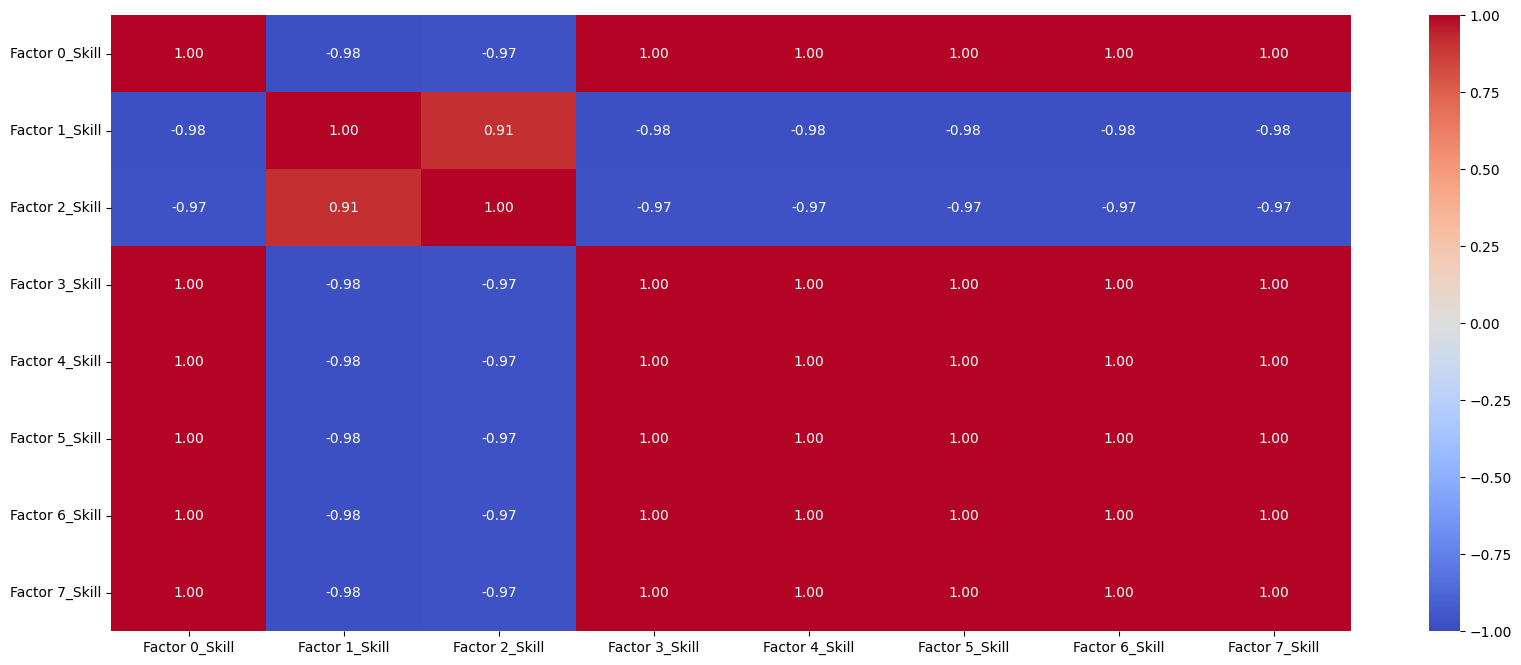

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
print("\n--- Internal Structure (Theta Correlation Matrix) ---")
theta_correlation_matrix = thetas_df.corr()
# Calculate and isolate the validity matrix
validity_matrix = theta_correlation_matrix.corr().loc[thetas_df.columns, theta_correlation_matrix.columns]

# Plot the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(validity_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.savefig("../result/theta_correlation.png")
plt.show()

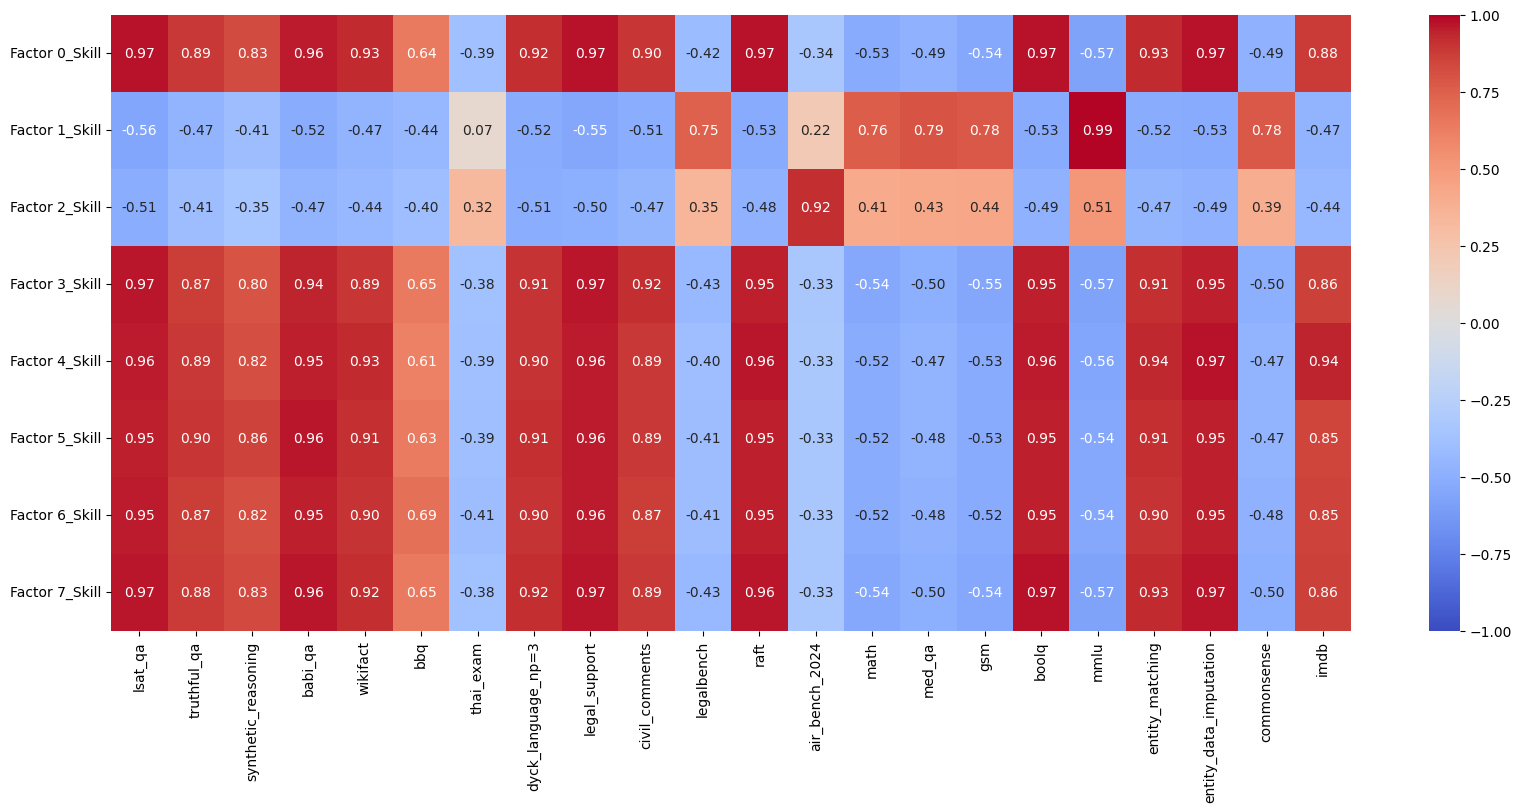

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'score_matrix_df' is your loaded (183, 22) DataFrame
score_matrix_df = pd.read_csv("../data/scenario_probs.csv")

# Combine the two dataframes
combined_df = pd.concat([thetas_df, score_matrix_df], axis=1)

# Calculate and isolate the validity matrix
validity_matrix = combined_df.corr().loc[thetas_df.columns, score_matrix_df.columns]

# Plot the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(validity_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.savefig("../result/external_validity_heatmap.png")
plt.show()